In [1]:
import numpy as np
import qiskit
import mitiq
import matplotlib.pyplot as plt
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error
from qiskit import *
from qiskit import IBMQ

In [2]:
#Define the functions used to build the Trotter circuit.
def h_Z(qc,h,dt):
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt): # Rabi coupling
    
    for i in range(5):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt): # nearest neighbor coupling
    
    qc.cx(0,1)
    
    qc.rz(-2*V*dt,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V*dt,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V*dt,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V*dt,4)
    
    qc.cx(3,4)

def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [3]:
#Parameters used for the Trotter cirucit
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

#NEED TO CHECK IF THIS IS ALLOWED
delta_t = .5

#CHECK THIS AS WELL
n = int(np.rint(T/delta_t))

NN=n

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

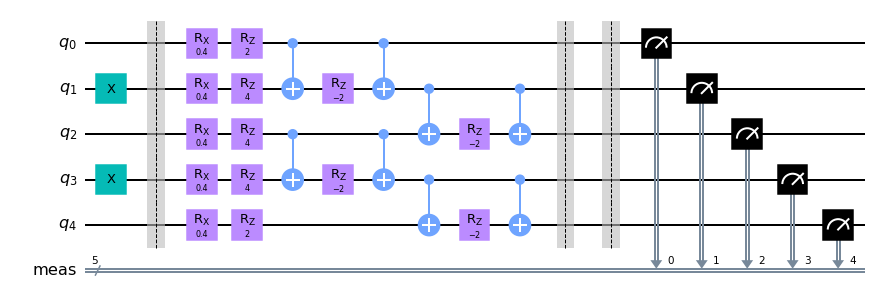

In [4]:
Trotter_circuit[1].draw(output='mpl')

In [5]:
#This cell sets up everything we need so the readout error mitigation will work.
from qiskit.test.mock import FakeVigo

backend = FakeVigo()

#This needs to be 5, since we have 5 qubits in our circuit.
qr = QuantumRegister(5)

noise_model = NoiseModel.from_backend(backend)

qubit_list = [0,1,2,3,4]

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

qasm_sim = Aer.get_backend('qasm_simulator')

t_qc = transpile(meas_calibs, backend) #Aer.get_backend('qasm_simulator'))
qobj = assemble(t_qc, shots=10000)

#note that the noise model isn't used until here. All the code in this cell above this comment is
# simply doing calibration of the circuit.
cal_results = qasm_sim.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

meas_filter = meas_fitter.filter

In [6]:
def post_selection(bit_str):
    """This function takes in a bitstring, and will return True iff 
    there is a 1 next to another 1 in the given bitstring.
    This does NOT consider a bitstring with 1s on either end as next to one another,
    i.e. given a string of the form '10...01', this function should return False"""
    new_str = '0' + bit_str[0:len(bit_str)]
    for i in range(0,len(bit_str)+1):
        if (new_str[i] == '1') & (new_str[i] == new_str[i-1]):
            return True
    return False

In [7]:
post_selection('10')

False

In [8]:
def Z(bitstring, bit):
    if bitstring[bit] == '1':
        return -1
    else:
        return 1

def ZZ_measurement(bitstring, bit1, bit2):
    return Z(bitstring, bit1) * Z(bitstring, bit2)

def ZZ_meas_expval(counts, bit1, bit2):
    copy_counts = counts.copy()
    total = []

    for x in counts.keys():
        if post_selection(x):
            copy_counts.pop(x)
    
    for x in copy_counts:
        total.append(copy_counts[x])
    
    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]

    prob = one_counts / total
    
    expval_list = []
    
    for x in copy_counts.keys():
        expval_list.append(ZZ_measurement(x,bit1,bit2) * copy_counts[x]/total)
    
    return sum(expval_list)

In [9]:
from qiskit.test.mock import FakeVigo

#Use a backend with an error model
backend = FakeVigo()

ideal_backend = Aer.get_backend('qasm_simulator')

#define the executor so mitiq will work. Note that the noise model is contained within here,
# so every time it is called, the result will be noisy.
def qiskit_multiqubit_executor(circuit, shots: 1000, qubit, want_ZZ_expval: False) -> float:
    """This function takes in a circuit, number of shots, and the qubit you are
    interested in, and returns either <Z_i> or <Z_i Z_{i+1}>, where i is the qubit you are intered in"""
    noise_model = NoiseModel.from_backend(backend)
    
    basis_gates = noise_model.basis_gates

    # execution of the experiment
    job = qiskit.execute(
        circuit,
        backend,
        basis_gates=basis_gates,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization
        optimization_level=0,
        #noise_model=noise_model,
        shots=shots,
        seed_transpiler=1,
        seed_simulator=1
    )
    results = job.result()
    mit_results = meas_filter.apply(results)
    counts = mit_results.get_counts()
    
    copy_counts = counts.copy()

    total = []

    for x in counts.keys():
        if post_selection(x):
            copy_counts.pop(x)

    for x in copy_counts:
        total.append(copy_counts[x])

    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]
    
    prob = one_counts / total
    
    ZZ_expval_list = []
    
    for x in copy_counts.keys():
        if qubit == 4:
            pass
        else:
            ZZ_expval_list.append(ZZ_measurement(x,qubit,qubit+1) * copy_counts[x]/total)
    
    ZZ_expval = sum(ZZ_expval_list)
    
    if want_ZZ_expval:
        return ZZ_expval
    
    else:
        return 2*prob - 1

def ideal_qiskit_multiqubit_executor(circuit, shots: 1000, qubit, want_ZZ_expval: False) -> float:
    """This function takes in a circuit, number of shots, and the qubit you are
    interested in, and returns either <Z_i> or <Z_i Z_{i+1}>, where i is the qubit you are interested in"""
    #noise_model = NoiseModel.from_backend(backend)
    
    #basis_gates = noise_model.basis_gates

    # execution of the experiment
    job = qiskit.execute(
        circuit,
        ideal_backend,
        #basis_gates=basis_gates,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization
        optimization_level=0,
        #noise_model=noise_model,
        shots=shots,
        seed_transpiler=1,
        seed_simulator=1
    )
    results = job.result()
    mit_results = meas_filter.apply(results)
    counts = mit_results.get_counts()
    
    copy_counts = counts.copy()

    total = []

    for x in counts.keys():
        if post_selection(x):
            copy_counts.pop(x)

    for x in copy_counts:
        total.append(copy_counts[x])

    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]
    
    prob = one_counts / total
    
    ideal_ZZ_expval_list = []
    
    for x in copy_counts.keys():
        if qubit == 4:
            pass
        else:
            ideal_ZZ_expval_list.append(ZZ_measurement(x,qubit,qubit+1) * copy_counts[x]/total)
    
    ideal_ZZ_expval = sum(ideal_ZZ_expval_list)
    
    return (ideal_ZZ_expval, 2*prob - 1)
    
#     if want_ZZ_expval:
#         return ideal_ZZ_expval
    
#     else:
#         return 2*prob - 1

In [10]:
ideal_qiskit_multiqubit_executor(Trotter_circuit[1],8192,0,False)

(-0.9917112730573595, -0.999999999999842)

In [11]:
qiskit_multiqubit_executor(Trotter_circuit[1],8192,0,False)

-0.9797215725583005

In [12]:
from functools import partial

input_shots = 8192
input_qubit = 0

temp = partial(qiskit_multiqubit_executor, shots = input_shots, qubit = input_qubit, 
               want_ZZ_expval = False)

print(mitiq.execute_with_zne(Trotter_circuit[1],temp))

-0.983684934302692


In [13]:
scale_factors = [1., 2., 3.]

linear_factory = mitiq.zne.inference.LinearFactory(scale_factors)

#This function is used to calculate the mitigated counts we will use to plot our data.
def Z_zne_expval(input_shots, input_qubit, t):
    temp = partial(qiskit_multiqubit_executor, shots = input_shots, qubit = input_qubit, 
                   want_ZZ_expval = False)
    return mitiq.execute_with_zne(Trotter_circuit[t],temp,factory = linear_factory, num_to_average = 3)

def ZZ_zne_expval(input_shots, input_qubit, t):
    temp = partial(qiskit_multiqubit_executor, shots = input_shots, qubit = input_qubit, 
                   want_ZZ_expval = True)
    return mitiq.execute_with_zne(Trotter_circuit[t],temp,factory = linear_factory, num_to_average = 3)

In [14]:
Z_zne_expval(8192,0,1)

-0.9866399064337178

In [15]:
num_qubits = int(Trotter_circuit[0].width()/2)

z_expval_dict = {}
# ideal_z_expval_dict = {}
zz_expval_dict = {}
# ideal_zz_expval_dict = {}

#Create a dictionary, where <Z> is stored for each time slice for each qubit.
for y in range(0,num_qubits):
    z_expval_dict.update({y:[]})
#     ideal_z_expval_dict.update({y:[]})
    zz_expval_dict.update({y:[]})
#     ideal_zz_expval_dict.update({y:[]})
    for x in range(0,len(Trotter_circuit)):
        a = ideal_qiskit_multiqubit_executor(Trotter_circuit[x],8192,y,False)
        z_expval_dict[y].append(Z_zne_expval(8192,y,x))
#         ideal_z_expval_dict[y].append(a[1])
        zz_expval_dict[y].append(ZZ_zne_expval(8192,y,x))
#         ideal_zz_expval_dict[y].append(a[0])

In [16]:
ideal_z_expval_dict = {}
ideal_zz_expval_dict = {}

for y in range(0,num_qubits):
    ideal_z_expval_dict.update({y:[]})
    ideal_zz_expval_dict.update({y:[]})
    for x in range(0,len(Trotter_circuit)):
        a = ideal_qiskit_multiqubit_executor(Trotter_circuit[x],8192,y,False)
        ideal_z_expval_dict[y].append(a[1])
        ideal_zz_expval_dict[y].append(a[0])

In [17]:
ideal_z_expval_dict
# z_expval_dict
# ideal_zz_expval_dict
# zz_expval_dict

{0: [-0.9999999999999686,
  -0.9999999999994125,
  -0.999999999998108,
  -0.9781548826925032,
  -0.8298525027094716,
  -0.6597474193746121,
  -0.386587726906394,
  -0.01211021902684839,
  0.3388287658340603,
  0.6707668545079593,
  0.9008667320229484,
  0.9692601866300705,
  0.9606113134250305,
  0.7851380402020918,
  0.4789171797649987,
  0.09932809715871449,
  -0.2977618552232406,
  -0.6060520976329969,
  -0.8554378314934592,
  -0.9702349806594677],
 1: [1.0,
  0.9917110803115374,
  0.7797599565472502,
  0.49775385667523064,
  0.07344585721437213,
  -0.2553909644054073,
  -0.5297228546688999,
  -0.7468814771480399,
  -0.869911825600379,
  -0.9357236050716612,
  -0.9846181882730244,
  -0.9999999999956399,
  -0.9999999999985479,
  -0.9999999999999933,
  -0.9975391009638347,
  -0.967527171235544,
  -0.8968114409043725,
  -0.7856433637476196,
  -0.5483210015980116,
  -0.2880473278989686],
 2: [-0.9999999999999823,
  -0.9999999999999755,
  -1.0,
  -0.9999999999996199,
  -0.965957998673250

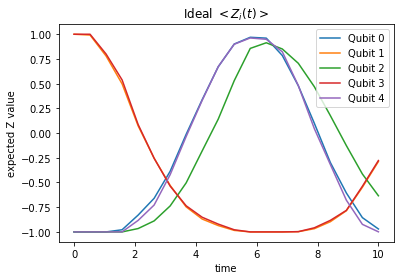

In [18]:
t=np.linspace(0,TT,NN)

fig,ax = plt.subplots()
ax.plot(t, ideal_z_expval_dict[0], label='Qubit 0')
ax.plot(t, ideal_z_expval_dict[1], label='Qubit 1')
ax.plot(t, ideal_z_expval_dict[2], label='Qubit 2')
ax.plot(t, ideal_z_expval_dict[3], label='Qubit 3')
ax.plot(t, ideal_z_expval_dict[4], label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("Ideal $<Z_i(t)>$")
ax.legend()

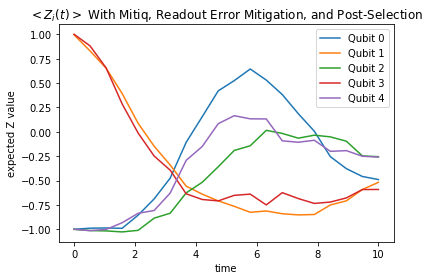

In [19]:
fig,ax = plt.subplots()
ax.plot(t, z_expval_dict[0], label='Qubit 0')
ax.plot(t, z_expval_dict[1], label='Qubit 1')
ax.plot(t, z_expval_dict[2], label='Qubit 2')
ax.plot(t, z_expval_dict[3], label='Qubit 3')
ax.plot(t, z_expval_dict[4], label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("$<Z_i(t)>$ With Mitiq, Readout Error Mitigation, and Post-Selection")
ax.legend()

In [20]:
def n_i(Z_i_expval):
    return (1 + Z_i_expval)/2

def n_i_n_iplus1(Z_i_expval,Z_iplus1_expval,prod_expval):
    return (1 + Z_i_expval + Z_iplus1_expval + prod_expval)/4

def alternative_method(Z_i,Z_iplus1):
    return n_i(Z_i) * n_i(Z_iplus1)

# n_i_dict = {}

# for y in ideal_z_expval_dict:
#     n_i_dict.update({y:[]})
#     for x in ideal_z_expval_dict[y]:
#         n_i_dict[y].append(n_i(x))

In [21]:
sum_list = []

for x in range(len(ideal_z_expval_dict[0])):
    temp_list = []
    for y in range(len(ideal_z_expval_dict)-1):
#         if y == 4:
#             break
        temp_list.append(n_i_n_iplus1(ideal_z_expval_dict[y][x], ideal_z_expval_dict[y+1][x],
                                     ideal_zz_expval_dict[y][x]))
    sum_list.append(sum(temp_list))

No handles with labels found to put in legend.


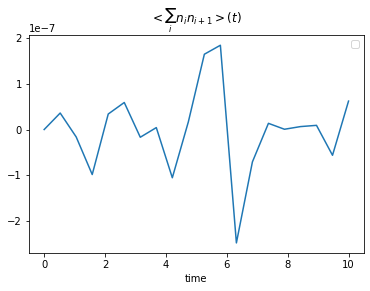

In [22]:
t=np.linspace(0,TT,NN)

fig,ax = plt.subplots()
ax.plot(t, sum_list)
ax.set_title('$<\sum_i n_i n_{i+1}>(t)$')
ax.set_xlabel('time')
ax.legend()

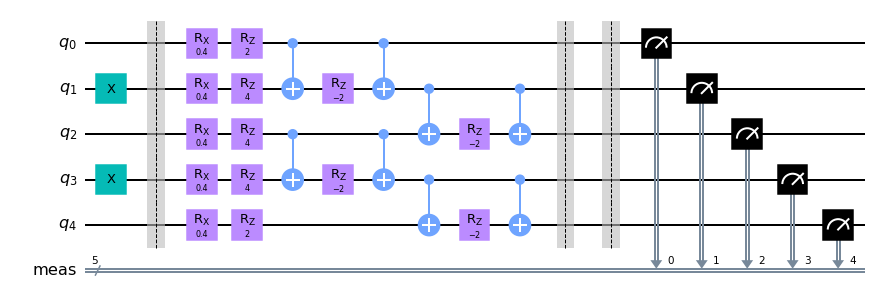

In [23]:
backend = qiskit.Aer.get_backend("qasm_simulator")
# backend = FakeVigo()

t = 1

job = qiskit.execute(Trotter_circuit[t],backend,shots=8192)
results = job.result()
counts = results.get_counts()

Trotter_circuit[t].draw(output='mpl')

In [24]:
print(counts)

{'01010': 6738, '01000': 273, '11010': 282, '01110': 295, '00010': 251, '01011': 246, '10010': 10, '11011': 11, '00000': 14, '11000': 9, '11110': 4, '01100': 14, '00011': 4, '11100': 2, '00110': 15, '01111': 14, '10111': 1, '01001': 6, '00100': 1, '10000': 2}


In [25]:
qubit = 4

copy_counts = counts.copy()

total = []

for x in counts.keys():
    if post_selection(x):
        copy_counts.pop(x)

for x in copy_counts:
    total.append(copy_counts[x])

total = sum(total)

one_counts = 0

for x in copy_counts.keys():
    if x[qubit] == '1':
        one_counts += copy_counts[x]

prob = one_counts / total

expval = 2*prob - 1

print(copy_counts)
        
print(one_counts)
print(total)
print(one_counts / total)
print(expval)

def post_selected_expval(counts, qubit):
    copy_counts = counts.copy()
    
    total = []

    for x in counts.keys():
        if post_selection(x):
            copy_counts.pop(x)

    for x in copy_counts:
        total.append(copy_counts[x])

    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]

    prob = one_counts / total

    expval = 2*prob - 1
    
    return expval

# post_selected_expval(counts,qubit) == expval

{'01010': 6738, '01000': 273, '00010': 251, '10010': 10, '00000': 14, '01001': 6, '00100': 1, '10000': 2}
6
7295
0.0008224811514736121
-0.9983550376970528


In [26]:
def Z(bitstring, bit):
    if bitstring[bit] == '1':
        return -1
    else:
        return 1
    
def ZZ_measurement(bitstring, bit1, bit2):
    return Z(bitstring, bit1) * Z(bitstring, bit2)

In [27]:
bitstring = '110101011'

for x in range(len(bitstring)):
    print(Z(bitstring, x))

-1
-1
1
-1
1
-1
1
-1
-1


In [28]:
expval_list = []

for x in copy_counts.keys():
    expval_list.append(ZZ_measurement(x,0,1) * copy_counts[x]/total)
    
print(sum(expval_list))

def ZZ_meas_expval(counts, bit1, bit2):
    copy_counts = counts.copy()
    total = []

    for x in counts.keys():
        if post_selection(x):
            copy_counts.pop(x)
    
    for x in copy_counts:
        total.append(copy_counts[x])
    
    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]

    prob = one_counts / total
    
    expval_list = []
    
    for x in copy_counts.keys():
        expval_list.append(ZZ_measurement(x,bit1,bit2) * copy_counts[x]/total)
    
    return sum(expval_list)

-0.927073337902673


In [29]:
print(ZZ_meas_expval(counts, 0, 1))

-0.927073337902673


In [30]:
expval_list

[-0.9236463331048663,
 -0.03742289239204935,
 0.034407128169979435,
 -0.0013708019191226869,
 0.0019191226867717615,
 -0.0008224811514736121,
 0.00013708019191226866,
 -0.00027416038382453733]

In [31]:
foo = (1 + post_selected_expval(counts,0) + post_selected_expval(counts,1) + sum(expval_list))/4

stuff1 = ideal_qiskit_multiqubit_executor(Trotter_circuit[1],8192,0,False)
stuff2 = ideal_qiskit_multiqubit_executor(Trotter_circuit[1],8192,1,False)

executor_result = n_i_n_iplus1(stuff1[1], stuff2[1], stuff1[0])

# print('The value of <n_0 n_1> =', foo)
print(foo)
print(executor_result)

2.7755575615628914e-17
-1.4917683671678006e-07


In [32]:
test_thing = []

for x in range(0,5-1):
    test_thing.append((1 + post_selected_expval(counts,x) + post_selected_expval(counts,x+1) + 
           ZZ_meas_expval(counts,x,x+1))/4)

test_thing = sum(test_thing)

print(test_thing)

0.0


In [33]:
sum_list = []

for y in range(0,20):
    job = qiskit.execute(Trotter_circuit[y],backend,shots=8192)
    results = job.result()
    counts = results.get_counts()
    test_list = []
#     print('t = ', y)
    for x in range(0,4):
        z_i = post_selected_expval(counts,x)
        z_iplus1 = post_selected_expval(counts,x+1)
        zz = ZZ_meas_expval(counts,x,x+1)
        test_list.append(n_i_n_iplus1(z_i, z_iplus1, zz))
#         test_list.append((1 + post_selected_expval(counts,x) + post_selected_expval(counts,x+1) + 
#                            ZZ_meas_expval(counts,x,x+1))/4)
    test_sum = sum(test_list)
        
    sum_list.append(test_sum)

sum_list

[0.0,
 -5.551115123125783e-17,
 -5.551115123125783e-17,
 5.551115123125783e-17,
 5.204170427930421e-17,
 3.8163916471489756e-17,
 6.938893903907228e-18,
 2.7755575615628914e-17,
 6.938893903907228e-17,
 4.163336342344337e-17,
 -1.3877787807814457e-17,
 -5.551115123125783e-17,
 5.551115123125783e-17,
 0.0,
 4.163336342344337e-17,
 -5.551115123125783e-17,
 2.7755575615628914e-17,
 6.938893903907228e-17,
 -1.214306433183765e-17,
 -5.724587470723463e-17]

In [34]:
stuff1 = ideal_qiskit_multiqubit_executor(Trotter_circuit[2],8192,0,False)
stuff2 = ideal_qiskit_multiqubit_executor(Trotter_circuit[2],8192,1,False)

executor_result = n_i_n_iplus1(stuff1[1], stuff2[1], stuff1[0])

In [35]:
ideal_z_expval_dict = {}
ideal_zz_expval_dict = {}

for y in range(0,num_qubits - 1):
    ideal_z_expval_dict.update({y:[]})
    ideal_zz_expval_dict.update({y:[]})
    for x in range(0,len(Trotter_circuit)):
        a = ideal_qiskit_multiqubit_executor(Trotter_circuit[x],8192,y,False)
        ideal_z_expval_dict[y].append(a[1])
        ideal_zz_expval_dict[y].append(a[0])

In [36]:
print(ideal_z_expval_dict[0])

[-0.9999999999768575, -0.9999999999998739, -0.999999999996854, -0.9781546828554973, -0.8298524105123537, -0.6597474256097793, -0.3865877138459305, -0.012110220119275539, 0.3388287524378992, 0.670766815680601, 0.9008671535986861, 0.9692600928851094, 0.9606116270700524, 0.785137937279631, 0.47891714918634687, 0.09932810113438384, -0.29776184429042796, -0.6060521949644226, -0.8554379430173238, -0.9702348939933321]


In [37]:
sum_list = []

for x in range(len(ideal_z_expval_dict[0])):
    temp_list = []
    for y in range(len(ideal_z_expval_dict)-1):
        if y == 4:
            pass
        temp_list.append(n_i_n_iplus1(ideal_z_expval_dict[y][x], ideal_z_expval_dict[y+1][x],
                                     ideal_zz_expval_dict[y][x]))
    sum_list.append(sum(temp_list))

In [38]:
sum_list

[-4.124367514179994e-12,
 1.1238856048589874e-07,
 -1.087198273630463e-07,
 -1.9328992863221206e-07,
 1.537496375006442e-08,
 -6.8373087375867e-08,
 2.8090335418839985e-08,
 1.6313500966758099e-09,
 1.8372137144950784e-10,
 -2.4347524552048583e-09,
 -3.451501062734508e-08,
 3.0685814805808675e-07,
 -3.2889270457081565e-07,
 1.6077174924689075e-08,
 2.3619673591990242e-08,
 -1.4132775505437678e-09,
 5.724569332454799e-09,
 -2.0070751644007956e-08,
 4.95663460015755e-08,
 -1.2948303040188902e-07]

No handles with labels found to put in legend.


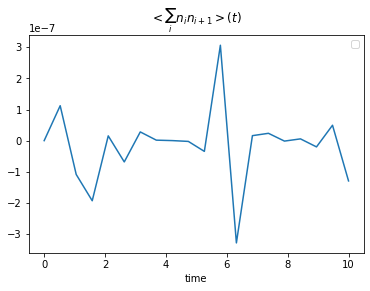

In [39]:
t=np.linspace(0,TT,NN)

fig,ax = plt.subplots()
ax.plot(t, sum_list)
ax.set_title('$<\sum_i n_i n_{i+1}>(t)$')
ax.set_xlabel('time')
ax.legend()